In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures 
from sqlalchemy import create_engine
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from lightgbm import LGBMRegressor

### Choosing the Dataset
Since, the Chicago Airbnb Dataset is very close to the house price prediction dataset, which I have worked on before, this specific dataset was chosen for the project.

In [2]:
chicago_airbnb = pd.read_csv(r"./chicago_airbnb.csv")

In [3]:
chicago_airbnb.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

### Selecting 100 rows randomly for generating live data

In [8]:
live_data= chicago_airbnb.sample(n=100, random_state= 42) #randomly selected 100 row
live_data.to_csv('live_data.csv', index= False)

In [9]:
# Checking number of rows in the live_data
live_data.shape

(100, 16)

In [10]:
# Removing the selected 100 rows from the live_data and chekcing the shape.
chicago_airbnb = chicago_airbnb[~chicago_airbnb.index.isin(live_data.index)]
chicago_airbnb.shape

(6297, 16)

In [11]:
live_data = pd.read_csv("live_data.csv")

### Sending the -100 rowed data to SQL.

In [12]:
host = r'127.0.0.1' # denotes that the db in a local installation
db = r'MSDS610' # db we just created
user = r'postgres' # using the postgres user for this demo
pw = r'1234' # this is the password established during installation
port = r'5433' # default port estabalished during install
schema = r'raw' # schema we just created
db_conn = create_engine(f"postgresql://{user}:{pw}@{host}:{port}/{db}")

In [13]:
table_name = r"chicago_airbnb"

In [14]:
chicago_airbnb.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')

6297

In [15]:
# Changing the default chicago_airbnb dataframe to the one stored in the Postgres.
sql="select tables.table_name from information_schema.tables where (table_schema ='"+schema+"')order by 1;"
tbl_df = pd.read_sql(sql, db_conn, index_col=None)
tbl_df

,table_name
0,chicago_airbnb
1,cleaning_guide


### Retrieving the new data from SQL.

In [16]:
connection_sql = f'select * from {schema}."chicago_airbnb";'
new_chicago_airbnb = pd.read_sql(connection_sql, db_conn)
new_chicago_airbnb.shape

(6297, 16)

In [17]:
new_chicago_airbnb.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6297 entries, 0 to 6296
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              6297 non-null   int64  
 1   name                            6297 non-null   object 
 2   host_id                         6297 non-null   int64  
 3   host_name                       6297 non-null   object 
 4   neighbourhood_group             0 non-null      object 
 5   neighbourhood                   6297 non-null   object 
 6   latitude                        6297 non-null   float64
 7   longitude                       6297 non-null   float64
 8   room_type                       6297 non-null   object 
 9   price                           6297 non-null   int64  
 10  minimum_nights                  6297 non-null   int64  
 11  number_of_reviews               6297 non-null   int64  
 12  last_review                     51

The Analytical Question:

How much should I charge per night for a rental property in Chicago, given the type of dwelling, location, size, and other features?
*How does the price of Airbnb listings in Chicago vary by neighborhood and room type, and what factors (such as minimum nights, number of reviews, and availability) are most strongly associated with higher prices?*

#### Target Variable:
*The target variable for this analysis is the `price` of the listing.*  
This variable is continuous and will be predicted based on other features like `room_type`, `neighbourhood`, `minimum_nights`, `number_of_reviews`, and `availability_365`.






In [18]:
chicago_airbnb_info ={ 
    "Column_name": ["id", "name", "host_id", "host_name",
        "neighbourhood", "latitude", "longitude", "room_type", "price",
        "minimum_nights", "number_of_reviews",
        "revi ews_per_month", "calculated_host_listings_count",
        "availability_365"],
    "Description": [ "Unique identifier for each listing.",
        "Title of the property listing.",
        "Unique identifier for the host.",
        "Name of the host.",
        "Specific neighborhood where the property is located.",
        "Latitude coordinate of the property.",
        "Longitude coordinate of the property.",
        "Type of room being rented (Entire home, Private room, etc.).",
        "Price per night for the property.",
        "Minimum number of nights required for booking.",
        "Total number of reviews received by the property.",
        "Average number of reviews per month.",
        "Total number of listings the host owns.",
        "Number of days the property is available for booking in a year."
    ],
    "Data Type" : [
        "Discrete", "Nominal", "Discrete", "Nominal",
        "Nominal", "Continuous", "Continuous", "Nominal", "Continuous",
        "Discrete", "Discrete", "Continuous", "Discrete",
        "Discrete"
    ]
}

chicago_airbnb_info_df=pd.DataFrame(chicago_airbnb_info)

chicago_airbnb_info_df.to_csv("dataset_description.csv",index= False)

print("Dataset Description as dataset_description.csv")

Dataset Description as dataset_description.csv


Target Variable : How much should I charge price per night
Feature Selection: According to me the most relevent feature that is important to determine price of the airbnb whould be price, neighbourhood, room type and minumum night the customer wants to spend. 

### Exploratory Data Analysis

In [19]:
new_chicago_airbnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2384,"Hyde Park - Walk to UChicago, 10 min to McCormick",2613,Rebecca,None,Hyde Park,41.78790,-87.58780,Private room,60,2,178,12/15/2019,2.56,1,353
1,4505,394 Great Reviews. 127 y/o House. 40 yds to tr...,5775,Craig & Kathleen,None,South Lawndale,41.85495,-87.69696,Entire home/apt,105,2,395,7/14/2020,2.81,1,155
2,7126,Tiny Studio Apartment 94 Walk Score,17928,Sarah,None,West Town,41.90289,-87.68182,Entire home/apt,60,2,384,3/8/2020,2.81,1,321
3,9811,Barbara's Hideaway - Old Town,33004,At Home Inn,None,Lincoln Park,41.91769,-87.63788,Entire home/apt,65,4,49,10/23/2019,0.63,9,300
4,10610,3 Comforts of Cooperative Living,2140,Lois,None,Hyde Park,41.79612,-87.59261,Private room,21,1,44,2/14/2020,0.61,5,168


Right off the start, we can see that the id, host_name, host_id, and the name columns do not affect our model in any way. So, we can safely remove them.

In [20]:
new_chicago_airbnb = new_chicago_airbnb.drop(columns = ["id", "name", "host_id", "host_name"], axis = 1, errors = "ignore")

Next, we will see if there are any alarming rates of NaN values in the dataset.

In [21]:
nan_counts_per_column = new_chicago_airbnb.isna().sum()
print(nan_counts_per_column)

neighbourhood_group               6297
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       1114
reviews_per_month                 1114
calculated_host_listings_count       0
availability_365                     0
dtype: int64


We see that there are 6297 null values in the neighbourhood_group feature. Let's see what the shape of the dataframe is so that we decide if we want to discard the column as a whole.

In [22]:
new_chicago_airbnb.shape

(6297, 12)

We see that all the rows of the neighbourhood_group column is empty. So, we will safely discard the column.

In [23]:
new_chicago_airbnb = new_chicago_airbnb.drop(columns = ["neighbourhood_group"], axis = 1, errors = "ignore")

In [24]:
new_chicago_airbnb.head()

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Hyde Park,41.78790,-87.58780,Private room,60,2,178,12/15/2019,2.56,1,353
1,South Lawndale,41.85495,-87.69696,Entire home/apt,105,2,395,7/14/2020,2.81,1,155
2,West Town,41.90289,-87.68182,Entire home/apt,60,2,384,3/8/2020,2.81,1,321
3,Lincoln Park,41.91769,-87.63788,Entire home/apt,65,4,49,10/23/2019,0.63,9,300
4,Hyde Park,41.79612,-87.59261,Private room,21,1,44,2/14/2020,0.61,5,168


We will check how the prices differ according to the neighbourhood.

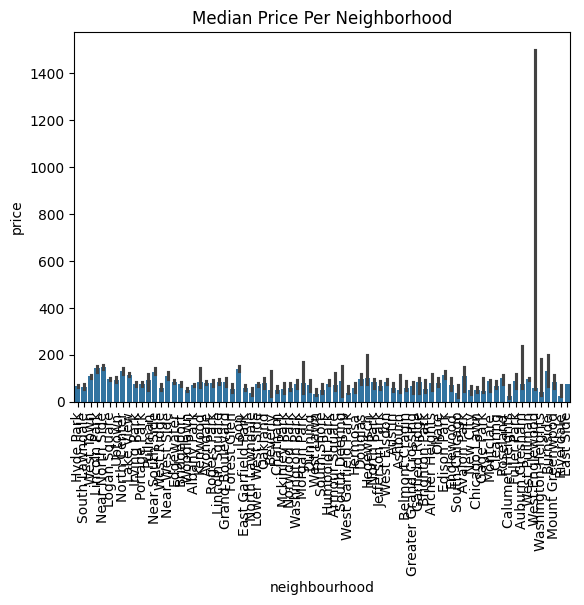

In [25]:
sns.barplot(x = "neighbourhood", y = "price", data = new_chicago_airbnb, estimator = np.median)
plt.xticks(rotation = 90)
plt.title("Median Price Per Neighborhood")
plt.show()

We immediately see that there is an outlier. Let's examine it.

In [26]:
Q1 = new_chicago_airbnb["price"].quantile(0.01)
Q3 = new_chicago_airbnb["price"].quantile(0.99)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = new_chicago_airbnb[(new_chicago_airbnb["price"] < lower_bound) | (new_chicago_airbnb["price"] > upper_bound)]
print(len(outliers))

14


After increasing the upper bound and managing the lower bound, we see that there are 14 rows that can easily be considered outliers. But, let's see the trend if they belong to luxurious neighbourhoods.


In [27]:
print(outliers[["neighbourhood", "price"]])

        neighbourhood  price
636         West Town  10000
1222        Lake View   9999
1442      Irving Park   3429
1677        Lake View   9999
2633  Lower West Side   3000
3534        Lake View   3690
3621     Lincoln Park   2450
3825        West Town   2788
3879        Lake View   9000
4085             Loop   9999
4086             Loop   9999
4087             Loop   9999
5465        West Town   7000
5931  Near North Side   3070


In [28]:
len(outliers["neighbourhood"].unique())

7

We see that there are 7 neighbourhoods that are on the outliers. They might not be outliers. Let's see what the data points look like.

In [29]:
outlier_nbs = outliers["neighbourhood"].unique()
outlier_nbs_df = new_chicago_airbnb[new_chicago_airbnb["neighbourhood"].isin(outlier_nbs)]

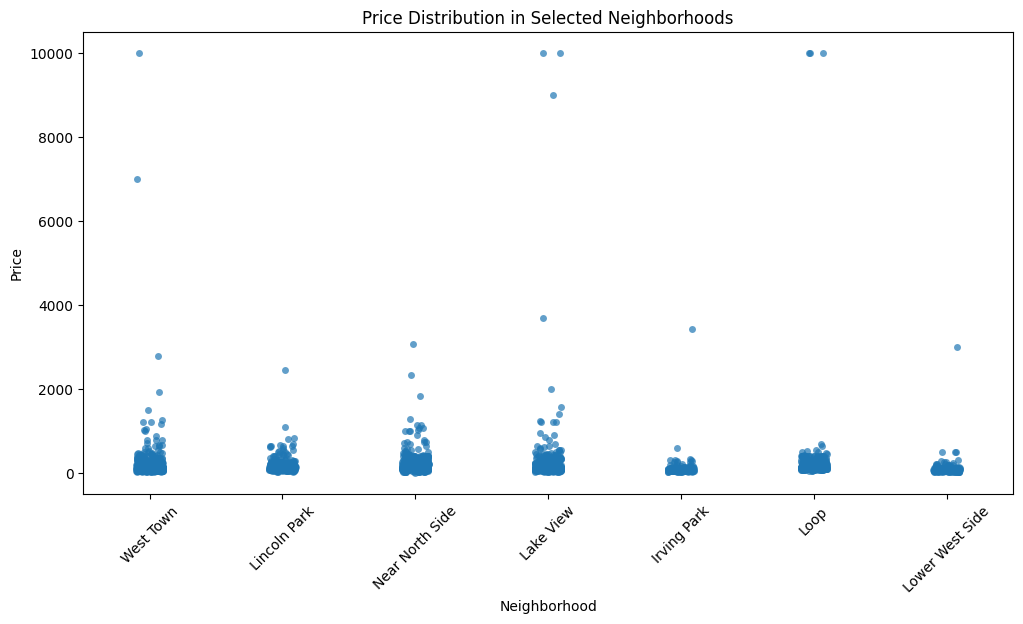

In [30]:
plt.figure(figsize = (12, 6))
sns.stripplot(data = outlier_nbs_df, x = "neighbourhood", y = "price", jitter = True, alpha = 0.7)
plt.xticks(rotation = 45)  # Rotateconnection_sql = f'select * from {schema}."Chicago_Airbnb";'
# new_chicago_airbnb = pd.read_sql(connection_sql, db_conn)
# new_chicago_airbnb.shape x-axis labels for better readability
plt.title("Price Distribution in Selected Neighborhoods")
plt.xlabel("Neighborhood")
plt.ylabel("Price")
plt.show()

After the plotting of the 7 neighbourhoods, we see that those prices can be considered outliers, and we will safely remove them to avoid skewness.

In [31]:
new_chicago_airbnb = new_chicago_airbnb[(new_chicago_airbnb["price"] >= lower_bound) & (new_chicago_airbnb["price"] <= upper_bound)]

In [32]:
new_chicago_airbnb.shape

(6283, 11)

Now, let's look at the distribution of the price.

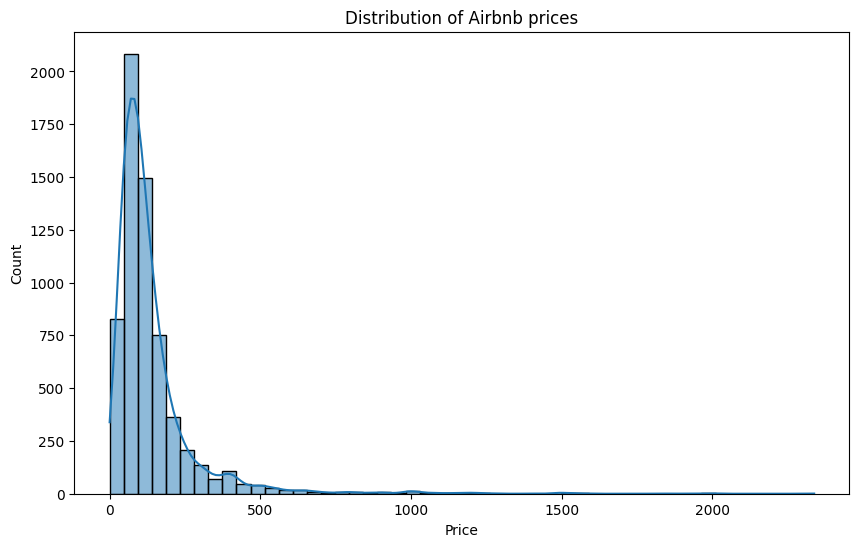

In [33]:
plt.figure(figsize = (10, 6))
sns.histplot(new_chicago_airbnb["price"], bins = 50, kde = True)
plt.title("Distribution of Airbnb prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

In [34]:
# Checking the price skewness
price_skewness = new_chicago_airbnb["price"].skew()
print(price_skewness)

4.988390022238522


Our data is still heavily skewed. So, we will try to decrease the number of outliers some more and evaluate again.

In [35]:
Q1 = new_chicago_airbnb["price"].quantile(0.20)
Q3 = new_chicago_airbnb["price"].quantile(0.80)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = new_chicago_airbnb[(new_chicago_airbnb["price"] < lower_bound) | (new_chicago_airbnb["price"] > upper_bound)]
print(len(outliers))

362


In [36]:
new_chicago_airbnb = new_chicago_airbnb[(new_chicago_airbnb["price"] >= lower_bound) & (new_chicago_airbnb["price"] <= upper_bound)]

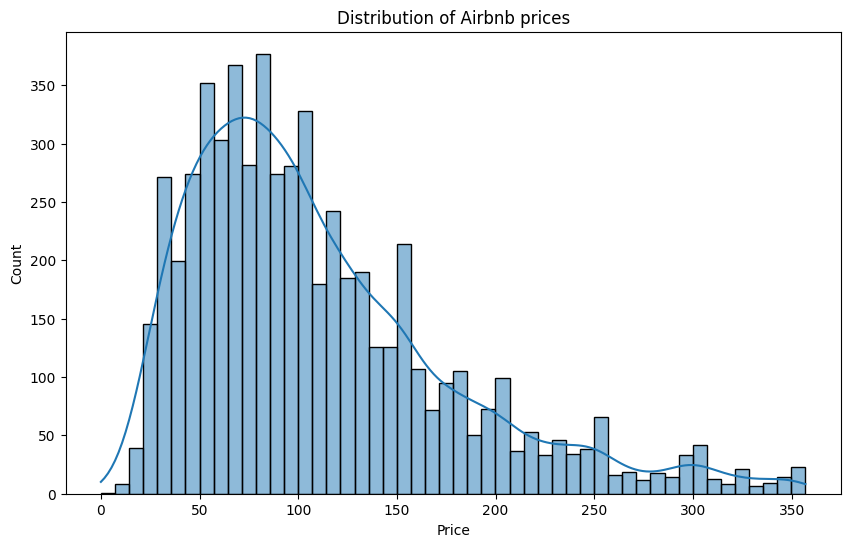

In [37]:
plt.figure(figsize = (10, 6))
sns.histplot(new_chicago_airbnb["price"], bins = 50, kde = True)
plt.title("Distribution of Airbnb prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

In [38]:
# Checking the price skewness
price_skewness = new_chicago_airbnb["price"].skew()
print(price_skewness)

1.227962887593027


Here, we have brought down the skewness from 4.9 to 1.2. So, we will keep the outliers discarded and build a model with the current data.

Here, in the data, the latitude and longitude do not have a real value except for the location provision. So, we will remove them.

In [39]:
new_chicago_airbnb = new_chicago_airbnb.drop(columns = ["latitude", "longitude"], axis = 1, errors = "ignore")

Checking the null values

In [40]:
new_chicago_airbnb.isna().sum()

neighbourhood                        0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       1016
reviews_per_month                 1016
calculated_host_listings_count       0
availability_365                     0
dtype: int64

We see that last_review and reviews per month are both null values of equal amount. This could be because the number of reviews for those properties are 0. Checking if the number of reivews are 0, and then replacing the null values with 0 for both former features.

In [41]:
# Checking number of review 0.
(new_chicago_airbnb["number_of_reviews"] == 0).sum()

1016

We have exact number of 0's on the number of reviews. So, we can change the null values in both the other columns to 0s.

In [42]:
# Fill missing numeric values with the 0s
new_chicago_airbnb.loc[new_chicago_airbnb["reviews_per_month"].isnull(), 'reviews_per_month'] = 0

We refrain from changing the null values in last_review to 0 because it has a date format. So, instead we will create a new feature that will be the number of days since the last review was posted. Then, change the last reviewed days to 0. **Statistically**, this is an anomaly because it could mean that the property was reviewed today. Thus, for now, we will get rid of the date column as a whole.

In [43]:
new_chicago_airbnb = new_chicago_airbnb.drop(columns = ["last_review"], axis = 1, errors = "ignore")

Since we removed the column relating to the host of the property, we can also remove the calculated_host_listings_count as it does not affect the data in any way.

In [44]:
new_chicago_airbnb = new_chicago_airbnb.drop(columns = ["calculated_host_listings_count"], axis = 1, errors = "ignore")

In [45]:
new_chicago_airbnb.head()

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365
0,Hyde Park,Private room,60,2,178,2.56,353
1,South Lawndale,Entire home/apt,105,2,395,2.81,155
2,West Town,Entire home/apt,60,2,384,2.81,321
3,Lincoln Park,Entire home/apt,65,4,49,0.63,300
4,Hyde Park,Private room,21,1,44,0.61,168


Cleaning guide tabel: Now here I want to make sure that the live data collected later matches the structure and cleaning steps of the training data. For this, I created a cleaning guide that outlines how to handle common issues like missing values or data format errors.

In [46]:
cleaning_guides= {
    "columns_name": ["neighbourhood", 
                     "minimum_nights",
                     "neighbourhood_group",
                     "price",
                     "room_type"],
    "cleaning_step": [ 
        "Check for missing values, handle categorical inconsistencies, and standardize room types.",
        "Handle missing or outlier values (e.g., price less than 0 or too high), ensure numeric values.",
        "Ensure values match recognized neighborhood group names (e.g., 'Downtown', 'Uptown').",
        "Handle missing or extreme values, ensure minimum nights is greater than 0.",
        "Standardize room types, handle missing values, and categorize them into consistent labels."
        ],
    "Data_type": ["Nominal", 
        "Continuous", 
        "Nominal", 
        "Discrete", 
        "Nominal"
        ]
}

cleaning_guides_chicago_airbnb= pd.DataFrame(cleaning_guides)
print(cleaning_guides_chicago_airbnb)

          columns_name                                      cleaning_step  \
0        neighbourhood  Check for missing values, handle categorical i...   
1       minimum_nights  Handle missing or outlier values (e.g., price ...   
2  neighbourhood_group  Ensure values match recognized neighborhood gr...   
3                price  Handle missing or extreme values, ensure minim...   
4            room_type  Standardize room types, handle missing values,...   

    Data_type  
0     Nominal  
1  Continuous  
2     Nominal  
3    Discrete  
4     Nominal  


In [47]:
cleaning_table_name = "cleaning_guide"
cleaning_guides_chicago_airbnb.to_sql(cleaning_table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')
print(f"Tabe {cleaning_table_name} stored to {schema}.")

Tabe cleaning_guide stored to raw.


Checking for any new null values

In [48]:
# Finding the missing values
missing_values = new_chicago_airbnb.isnull().sum()
print(missing_values)

neighbourhood        0
room_type            0
price                0
minimum_nights       0
number_of_reviews    0
reviews_per_month    0
availability_365     0
dtype: int64


Now, let's look at the minimum nights column.

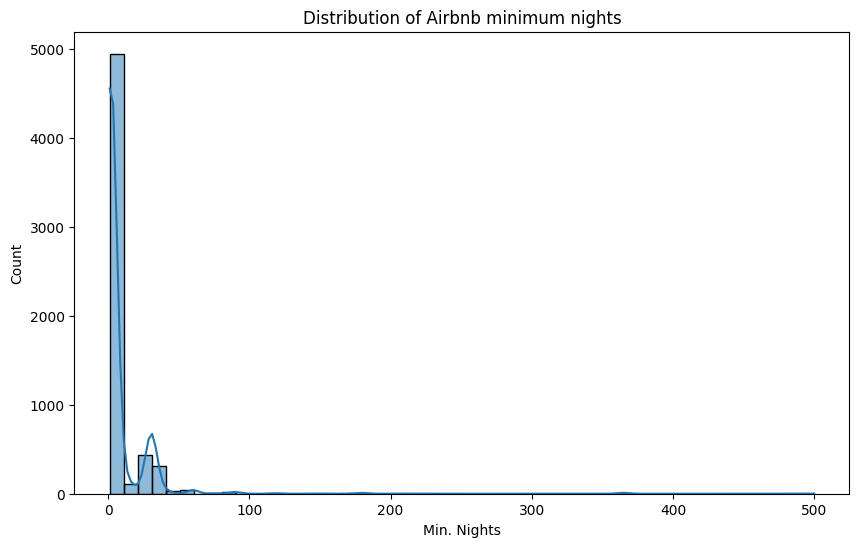

In [49]:
plt.figure(figsize = (10, 6))
sns.histplot(new_chicago_airbnb["minimum_nights"], bins = 50, kde = True)
plt.title("Distribution of Airbnb minimum nights")
plt.xlabel("Min. Nights")
plt.ylabel("Count")
plt.show()

The data is highly skewed so, we will apply some transformations during feature engineering.

Let's look at the distribution of the number_of_reviews.

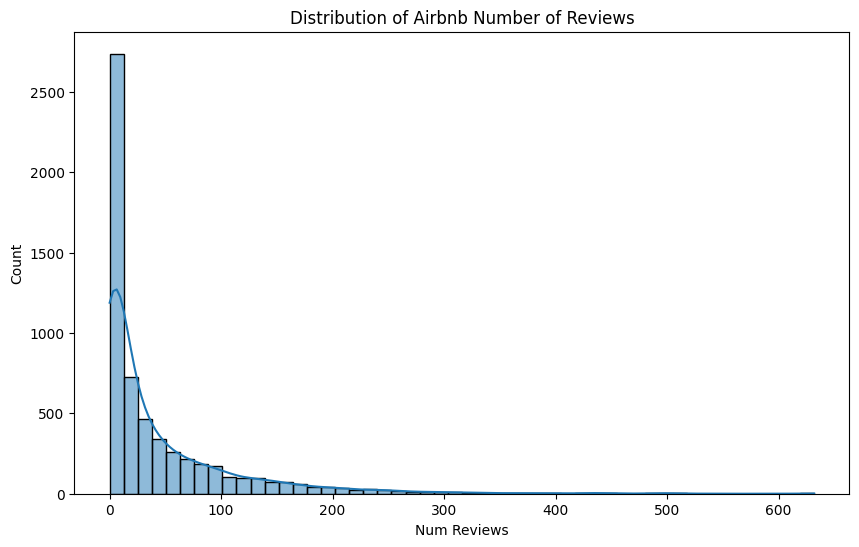

In [50]:
plt.figure(figsize = (10, 6))
sns.histplot(new_chicago_airbnb["number_of_reviews"], bins = 50, kde = True)
plt.title("Distribution of Airbnb Number of Reviews")
plt.xlabel("Num Reviews")
plt.ylabel("Count")
plt.show()

Now, for the reviews_per_month and availability_365

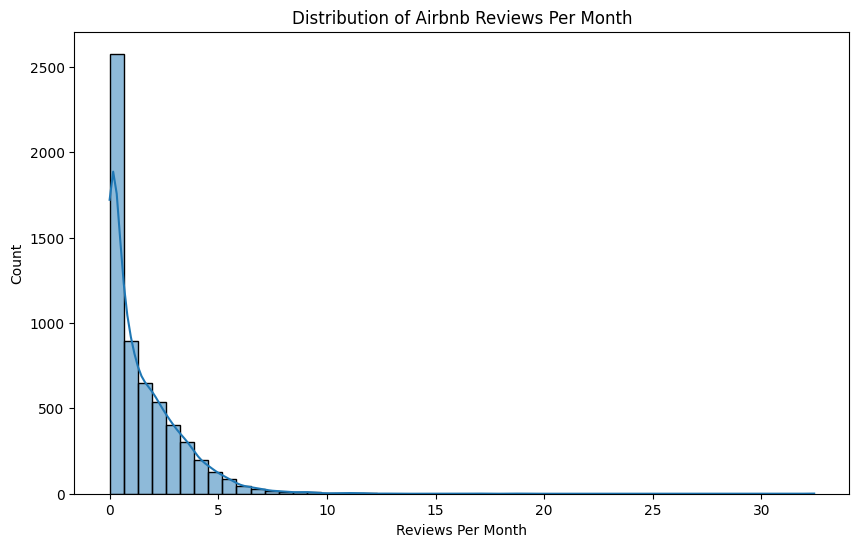

In [51]:
plt.figure(figsize = (10, 6))
sns.histplot(new_chicago_airbnb["reviews_per_month"], bins = 50, kde = True)
plt.title("Distribution of Airbnb Reviews Per Month")
plt.xlabel("Reviews Per Month")
plt.ylabel("Count")
plt.show()

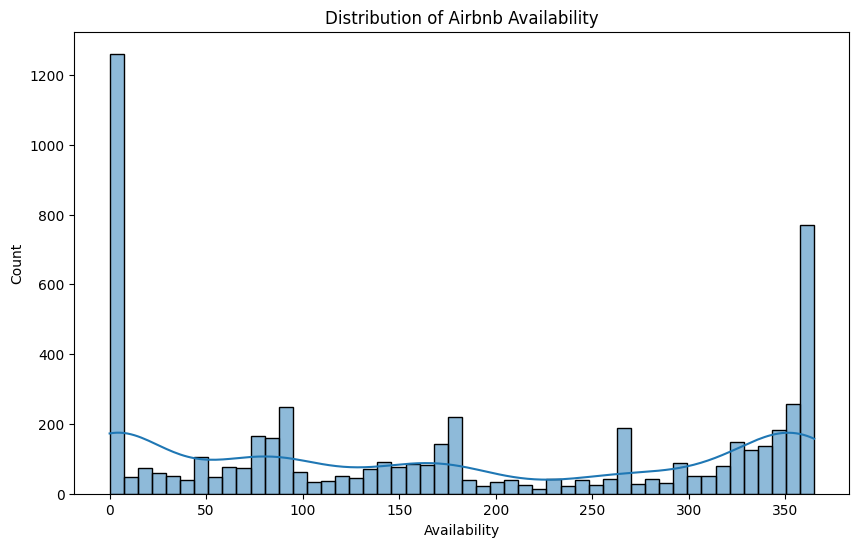

In [52]:
plt.figure(figsize = (10, 6))
sns.histplot(new_chicago_airbnb["availability_365"], bins = 50, kde = True)
plt.title("Distribution of Airbnb Availability")
plt.xlabel("Availability")
plt.ylabel("Count")
plt.show()

The reviews_per_month has most of the values 0 as the number_of_reviews. But, the availability_365 has an interesting distribution. So, we will take care of both in the feature engineering section.

### Now, that we have cleaned the data, we will go forward with feature engineering.

First, we check if any anomalies in the data. We check if there are any listing that have minimum_nights more than 365. If yes, and the data doesn't align properly with the rest of the listing, we will not be using that data point.

In [53]:
min_nights_df = new_chicago_airbnb[new_chicago_airbnb["minimum_nights"] >= 365]
min_nights_df

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365
31,Uptown,Private room,125,365,5,0.05,0
86,Uptown,Private room,99,365,0,0.00,365
87,Uptown,Entire home/apt,299,365,16,0.17,365
180,Lincoln Park,Entire home/apt,140,365,2,0.03,263
798,Lake View,Entire home/apt,125,365,27,0.47,365
823,Lincoln Square,Entire home/apt,64,365,99,1.80,365
979,Lake View,Private room,125,365,84,1.66,0
1197,Lake View,Private room,115,365,76,1.61,361
1746,Logan Square,Entire home/apt,200,365,0,0.00,365
4410,Greater Grand Crossing,Private room,25,500,0,0.00,365


We see that there is one listing with minimum_nights 500. The price being exceptionally low, and the reviews being 0, we can decide to safely remove that row from the further calculations.

In [54]:
new_chicago_airbnb = new_chicago_airbnb[new_chicago_airbnb['minimum_nights'] <= 365]

In [55]:
new_chicago_airbnb.shape

(5920, 7)

Now, we start creating new features for our dataset.

In [56]:
# Since room type is one of the basic categorical columns in the dataset. We see how many unique calues are present for it.
new_chicago_airbnb["room_type"].unique()

array(['Private room', 'Entire home/apt', 'Shared room', 'Hotel room'],
      dtype=object)

Since, there are only 4 unique values in the room_type column, we one-hot encode the column and create 4 new features.

In [57]:
new_chicago_airbnb = pd.get_dummies(new_chicago_airbnb, columns=['room_type'], drop_first = False)

In [58]:
new_chicago_airbnb = new_chicago_airbnb.rename(columns = {
    "room_type_Entire home/apt": "room_type_entire_home_apt",
    "room_type_Hotel room": "room_type_hotel_room",
    "room_type_Private room": "room_type_private_room",
    "room_type_Shared room": "room_type_shared_room"
})

Now, we check if we have any more categorical columns that can be one-hot encoded.

In [59]:
new_chicago_airbnb["neighbourhood"].nunique()

77

The neighbourhood column is another categorical column but there are 77 unique values in the column. So, we use label encoding rather than one-hot encoding.

In [60]:
label_encoder = LabelEncoder()
new_chicago_airbnb["neighbourhood"] = label_encoder.fit_transform(new_chicago_airbnb["neighbourhood"])

# Normalization

We see that the data is very highly skewed for minimum_nights. So, let's check the outliers.

In [61]:
Q1 = new_chicago_airbnb["minimum_nights"].quantile(0.10)
Q3 = new_chicago_airbnb["minimum_nights"].quantile(0.90)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = new_chicago_airbnb[(new_chicago_airbnb["minimum_nights"] < lower_bound) | (new_chicago_airbnb["minimum_nights"] > upper_bound)]
print(len(outliers))

56


Here, since minimum_nights is an ordinal feature. Let's try to log transform the feature.

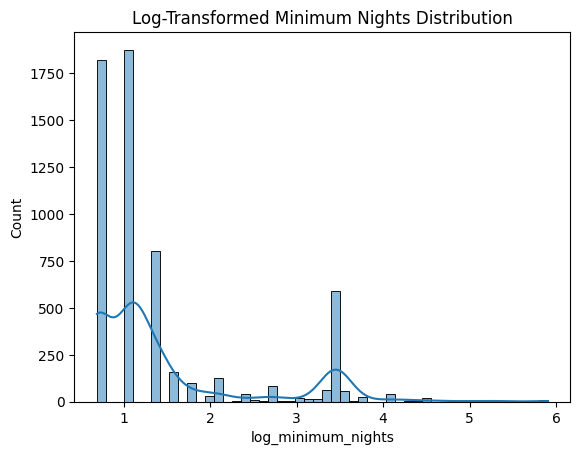

In [62]:
new_chicago_airbnb["log_minimum_nights"] = np.log1p(new_chicago_airbnb["minimum_nights"])
sns.histplot(new_chicago_airbnb["log_minimum_nights"], kde = True, bins = 50)
plt.title("Log-Transformed Minimum Nights Distribution")
plt.show()

Even, though the distribution is not normal, the value differences are low after log transformation.

Now, let's check the skewness of the Number of Reviews feature.

In [63]:
new_chicago_airbnb["number_of_reviews"].skew()

2.843598328401853

The skewness is still pretty high. Let's try to normalize this feature as well.

In [64]:
new_chicago_airbnb["log_number_of_reviews"] = np.log1p(new_chicago_airbnb[["number_of_reviews"]])

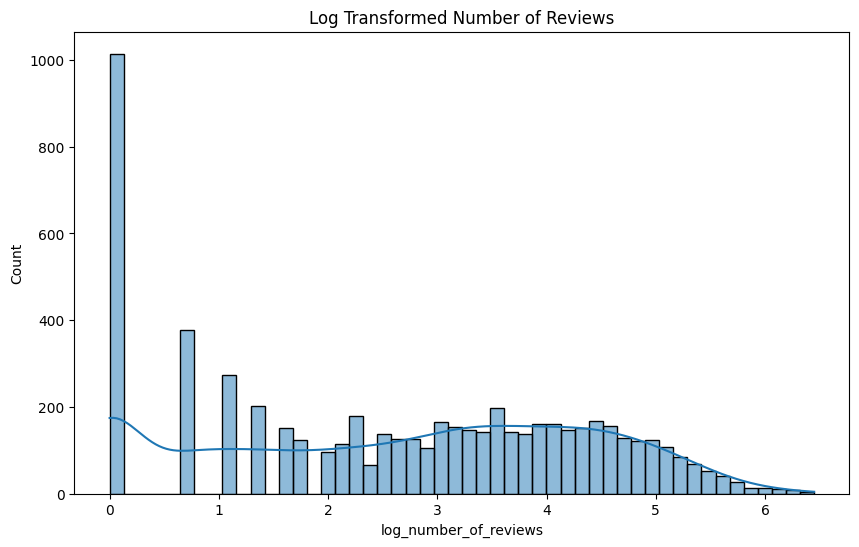

In [65]:
plt.figure(figsize = (10, 6))
sns.histplot(new_chicago_airbnb["log_number_of_reviews"], kde = True, bins = 50)
plt.title("Log Transformed Number of Reviews")
plt.show()

Now, let's check the skewness of the Reviews Per Month feature.

In [66]:
new_chicago_airbnb["reviews_per_month"].skew()

2.6700098154544185

In [67]:
new_chicago_airbnb["log_reviews_per_month"] = np.log1p(new_chicago_airbnb[["reviews_per_month"]])

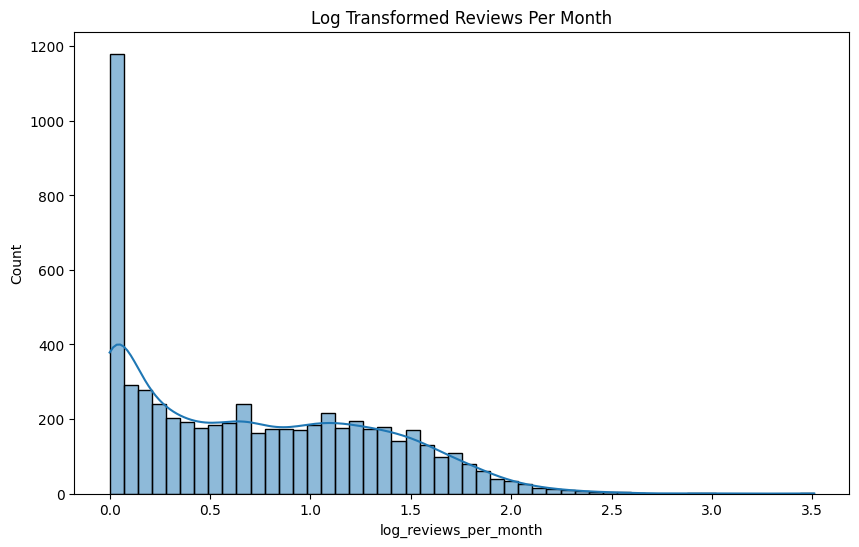

In [68]:
plt.figure(figsize = (10, 6))
sns.histplot(new_chicago_airbnb["log_reviews_per_month"], kde = True, bins = 50)
plt.title("Log Transformed Reviews Per Month")
plt.show()

Now, let's check the skewness of the availability_365.

In [69]:
new_chicago_airbnb["availability_365"].skew()

0.11482505273278644

The skewness of the availability_365 is relatively low. So, we will keep it as is.

In [70]:
new_chicago_airbnb.columns

Index(['neighbourhood', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'availability_365', 'room_type_entire_home_apt',
       'room_type_hotel_room', 'room_type_private_room',
       'room_type_shared_room', 'log_minimum_nights', 'log_number_of_reviews',
       'log_reviews_per_month'],
      dtype='object')

In [71]:
selected_features = ['availability_365', 'number_of_reviews']
X_selected = new_chicago_airbnb[selected_features]

poly = PolynomialFeatures(degree = 2, include_bias = False)
poly_features = poly.fit_transform(new_chicago_airbnb[["availability_365", "number_of_reviews"]])

poly_feature_names = poly.get_feature_names_out(selected_features)
X_poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=new_chicago_airbnb.index)

new_chicago_airbnb = pd.concat([new_chicago_airbnb, X_poly_df], axis=1)
new_chicago_airbnb.drop(columns=selected_features, inplace=True)

In [72]:
new_chicago_airbnb.columns

Index(['neighbourhood', 'price', 'minimum_nights', 'reviews_per_month',
       'room_type_entire_home_apt', 'room_type_hotel_room',
       'room_type_private_room', 'room_type_shared_room', 'log_minimum_nights',
       'log_number_of_reviews', 'log_reviews_per_month', 'availability_365^2',
       'availability_365 number_of_reviews', 'number_of_reviews^2'],
      dtype='object')

Since, we have log transformed minimum_nights, number_of_reviews, and reviews_per_month, we will drop the original columns and build the model.

In [73]:
new_chicago_airbnb = new_chicago_airbnb.drop(columns = ["minimum_nights", "number_of_reviews", "reviews_per_month"], axis = 1, errors = "ignore")

In [74]:
new_chicago_airbnb

,neighbourhood,price,room_type_entire_home_apt,room_type_hotel_room,room_type_private_room,room_type_shared_room,log_minimum_nights,log_number_of_reviews,log_reviews_per_month,availability_365^2,availability_365 number_of_reviews,number_of_reviews^2
0,33,60,False,False,True,False,1.098612,5.187386,1.269761,124609.0,62834.0,31684.0
1,64,105,True,False,False,False,1.098612,5.981414,1.337629,24025.0,61225.0,156025.0
2,75,60,True,False,False,False,1.098612,5.953243,1.337629,103041.0,123264.0,147456.0
3,38,65,True,False,False,False,1.609438,3.912023,0.488580,90000.0,14700.0,2401.0
4,33,21,False,False,True,False,0.693147,3.806662,0.476234,28224.0,7392.0,1936.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6291,75,344,True,False,False,False,0.693147,0.000000,0.000000,126025.0,0.0,0.0
6292,48,146,True,False,False,False,1.098612,0.000000,0.000000,32400.0,0.0,0.0
6293,48,195,True,False,False,False,1.098612,0.000000,0.000000,32400.0,0.0,0.0
6295,75,53,False,False,True,False,3.496508,0.000000,0.000000,6889.0,0.0,0.0


In [75]:
table_name = r'cleaned_chicago_airbnb'
schema = r"cleaned"

In [76]:
sql="select tables.table_name from information_schema.tables where (table_schema ='"+schema+"')order by 1;"
tbl_df = pd.read_sql(sql, db_conn, index_col=None)
tbl_df

,table_name
0,cleaned_chicago_airbnb


In [77]:
new_chicago_airbnb.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')
print(f"Data saved to {table_name} of schema: {schema}")

Data saved to cleaned_chicago_airbnb of schema: cleaned


# Model Building and Finalizing
Now, we define the data splits and build a model.

In [78]:
# Separating the feature columns and target column
X = new_chicago_airbnb.drop(columns=['price'])
y = new_chicago_airbnb['price']

# Step 4: Split the data into training, validation, and test sets (3-way split)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 4440
Validation set size: 740
Test set size: 740


In [79]:
X_train.columns

Index(['neighbourhood', 'room_type_entire_home_apt', 'room_type_hotel_room',
       'room_type_private_room', 'room_type_shared_room', 'log_minimum_nights',
       'log_number_of_reviews', 'log_reviews_per_month', 'availability_365^2',
       'availability_365 number_of_reviews', 'number_of_reviews^2'],
      dtype='object')

Traning the Random Forest Regression Model

In [80]:
rf_model = RandomForestRegressor(n_estimators=5000, random_state=42, max_depth = 500, max_leaf_nodes = 200)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=500, max_leaf_nodes=200, n_estimators=5000,
                      random_state=42)

In [81]:
y_val_pred = rf_model.predict(X_val)
mse = mean_squared_error(y_val, y_val_pred)
print(f"Mean Squared Error on validation set: {mse}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error on validation set: {rmse}")

Mean Squared Error on validation set: 2835.724670952408
Root Mean Squared Error on validation set: 53.25152271017617


Since our model RMSE is still a bit high, we will try a few ways to bring it down.

In [82]:
param_grid = {
    "n_estimators": [100, 200, 300, 500, 1000],
    "max_depth": [10, 15, 20, 25, 30],
    "min_samples_split": [2, 5, 10, 20, 25],
    "min_samples_leaf": [1, 4, 8, 16, 32]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state = 42),
                                                 param_grid = param_grid,
                                                 cv = 3,
                                                 n_jobs = -1,
                                                 scoring = "neg_root_mean_squared_error")
grid_search.fit(X_train, y_train)

print(f"Best params: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Best params: {'max_depth': 25, 'min_samples_leaf': 4, 'min_samples_split': 25, 'n_estimators': 1000}
Best score: -55.13426452875418


We do have more RMSE from the Grid Search. But, we will try a few parameters to check if it goes own anymore.

In [83]:
# Training the model
rf_model = RandomForestRegressor(n_estimators=200, random_state=42, max_depth = 15, min_samples_leaf = 4, min_samples_split = 20)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=15, min_samples_leaf=4, min_samples_split=20,
                      n_estimators=200, random_state=42)

In [84]:
y_val_pred = rf_model.predict(X_val)
mse = mean_squared_error(y_val, y_val_pred)
print(f"Mean Squared Error on validation set: {mse}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error on validation set: {rmse}")

Mean Squared Error on validation set: 2739.1725480349446
Root Mean Squared Error on validation set: 52.33710488778439


Since, the above RMSE is the lowest we have for now. We will use this model.

In [86]:
joblib.dump(rf_model, "randomforest_model.joblib")
print("Random Forest Model saved successfully.")

Random Forest Model saved successfully.


Choosing a new model to check if MSE comes down. XGBoost Model

In [ ]:
# Choosing a new model
xgb = XGBRegressor(n_estimators = 5000, learning_rate = 0.1, max_depth = 100)
xgb.fit(X_train, y_train)

In [ ]:
y_val_pred = xgb.predict(X_val)
mse = mean_squared_error(y_val, y_val_pred)
print(f"Mean Squared Error on validation set: {mse}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error on validation set: {rmse}")

Since, the XGBoost model RMSE is too high. We will check with one final model. LightGBM.

In [ ]:
lgbm = LGBMRegressor(
    n_estimators=1000,      # Number of boosting rounds (trees)
    learning_rate=0.01,    # Lower learning rate for better accuracy
    max_depth=25,          # Prevents overfitting
    num_leaves=100,         # Controls model complexity
    min_child_samples=10,  # Minimum data in a leaf
    subsample=0.5,         # Row sampling to prevent overfitting
    colsample_bytree=0.5,  # Feature sampling
    random_state=42,
    n_jobs=-1              # Use all CPU cores
)

# Train the model
lgbm.fit(X_train, y_train)

In [ ]:
y_val_pred = lgbm.predict(X_val)
mse = mean_squared_error(y_val, y_val_pred)
print(f"Mean Squared Error on validation set: {mse}")
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error on validation set: {rmse}")

The results between the RFRegression and the LGBMRegressor are not too far apart.

# Feature Engineering and Normalization

## 1. Feature Engineering:
We created the following new features to improve the model's performance:

### a) Price per Room Type:
This feature calculates the price per room type based on the availability of the listing:
```python
chicago_airbnb_cleaned['price_per_room_type'] = chicago_airbnb_cleaned['price'] / chicago_airbnb_cleaned['availability_365']

In [ ]:
# Create a new feature: price_per_room_type
chicago_airbnb['price_per_room_type'] = chicago_airbnb['price'] / chicago_airbnb['availability_365']

# Create a new feature: reviews_to_nights_ratio
chicago_airbnb['reviews_to_nights_ratio'] = chicago_airbnb['number_of_reviews'] / chicago_airbnb['availability_365']





In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Select numerical features for normalization
numerical_features = ['price', 'minimum_nights', 'availability_365', 'number_of_reviews']

# Initialize the Min-Max scaler
scaler = MinMaxScaler()

# Apply Min-Max scaling
chicago_airbnb[numerical_features] = scaler.fit_transform(chicago_airbnb[numerical_features])


Normalization of Numerical Features
Normalization ensures that numerical features with different scales are standardized so that they have equal influence on the model. Some features like price, minimum_nights, number_of_reviews, and availability_365 might need normalization.

Min-Max Normalization:
For numerical features such as price, minimum_nights, and availability_365, you can use Min-Max scaling to normalize the values to a range between 0 and 1.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Assuming 'chicago_airbnb_cleaned' is your dataset
X = chicago_airbnb.drop(columns=['price'])
y = chicago_airbnb['price']

# Step 1: Replace infinity values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Step 2: Fill NaN values with the mean of each column
X.fillna(X.mean(), inplace=True)

# Step 3: Clip large values to a reasonable range (e.g., between -1e10 and 1e10)
X = X.clip(-1e10, 1e10)

# Step 4: Split the data into training, validation, and test sets (3-way split)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")




In [ ]:
# Step 5: Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 6: Evaluate the model on the validation set
y_val_pred = rf_model.predict(X_val)
mse = mean_squared_error(y_val, y_val_pred)
print(f"Mean Squared Error on validation set: {mse}")

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for RandomForestRegressor
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters
print(f"Best parameters found: {grid_search.best_params_}")


In [ ]:
# Predict on the test set using the best model
best_rf_model = grid_search.best_estimator_
y_test_pred = best_rf_model.predict(X_test)

# Evaluate performance on the test set
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Mean Squared Error on test set: {test_mse}")


In [ ]:
import joblib

# Save the trained model
joblib.dump(best_rf_model, 'random_forest_model.joblib')


In [ ]:
# Save X_val and y_val to CSV files
X_val.to_csv('X_val.csv', index=False)
y_val.to_csv('y_val.csv', index=False)


Documentation (Markdown):


Choice of Algorithm:
For our analysis we use Random Forest model. Because Random Forest is chosen due to its robustness, ability to handle non-linear relationships, and capability to handle feature interactions effectively.
Data Split:

We split the dataset into three parts:

Training Set (60%): This portion of the data is used to train the model. It helps the algorithm learn the patterns in the data.

Validation Set (20%): This set is used during model tuning to evaluate how the model is performing while making adjustments to hyperparameters. It acts as a check to prevent overfitting and ensures that the model generalizes well to unseen data.

Test Set (20%): Once the model is trained and tuned, we use the test set to evaluate its final performance. This set is used to estimate how well the model will perform in real-world scenarios

Hyperparameter Tuning
In this case, we used the Random Forest Regressor model, and the goal was to optimize the following hyperparameters to improve performance:

n_estimators (Number of Trees): This parameter controls how many trees are in the forest. More trees generally lead to better performance but also increase computation time. We started with the default (100) and experimented with increasing it to see if performance improved.

max_depth (Maximum Depth of Each Tree): The depth of a tree controls how deep the decision tree grows. If the depth is too large, the model might overfit. If it's too small, the model may underfit. We tested various depths to find the right balance.

min_samples_split (Minimum Samples to Split a Node): This parameter controls how many samples are needed to split a node in the tree. Increasing this value prevents the model from learning overly specific patterns (i.e., overfitting).

We used a grid search or randomized search (depending on your approach) to find the best combination of these parameters, ensuring that the model works optimally without overfitting.


Model Evaluation
Evaluation Metrics
To evaluate the performance of the Random Forest model, we used Mean Squared Error (MSE). MSE measures how well the model predicts the target variable (in this case, price).

MSE is calculated by averaging the squared differences between predicted values and actual values. A lower MSE indicates better model performance.
The steps we followed for evaluation are:

On the Validation Set: After training and tuning the model, we used the validation set to see how well the model was performing during the training process. This helps us decide whether to adjust any hyperparameters or if the model is generalizing well.

On the Test Set: After finalizing the model, we evaluated it on the test set. This provides an unbiased estimate of the model's performance on new, unseen data.

Data Cleaning and Preparation
Now, the live data may not be in the exact format that our trained model expects. This means we need to process it so it matches our training data.

In [ ]:
live_data["price"] = live_data["price"].astype(float)


In [ ]:
def prepare_live_data(df):
    """
    This function takes raw live data and prepares it for prediction.
    It ensures missing values are handled, categorical values are encoded,
    and columns match the trained model.
    """

    # Handle missing values
    df.fillna(df.mean(), inplace=True)

    # Encode categorical variables (assuming we used one-hot encoding in training)
    df = pd.get_dummies(df)

    # Ensure the column order matches the trained model's input
    missing_cols = set(X_train.columns) - set(df.columns)
    
    # Add missing columns with 0 values
    for col in missing_cols:
        df[col] = 0

    # Reorder columns to match X_train
    df = df[X_train.columns]

    return df

# Apply the function
live_data_prepared = prepare_live_data(live_data)

# Check if the data is now in the right format
print(live_data_prepared.head())


In [ ]:
print(chicago_airbnb.columns)


In [ ]:
# Assuming chicago_airbnb_test contains the same data as X_test
chicago_airbnb.loc[X_test.index, 'predictions'] = y_test_pred

# Verify the DataFrame
print(chicago_airbnb.head())  # Check if predictions were added correctly


In [ ]:
print("X_test shape:", X_test.shape)
print("Predictions shape:", best_rf_model.predict(X_test).shape)


In [ ]:
# Make predictions
predictions = model.predict(X_test)

# Ensure the length of predictions matches the number of rows in X_test
assert len(predictions) == len(X_test), "Length mismatch between predictions and X_test"

# Assign predictions back to the 'chicago_airbnb' DataFrame
# Assuming 'X_test' corresponds to a subset of 'chicago_airbnb', use the index of X_test
chicago_airbnb.loc[X_test.index, 'predictions'] = predictions

# Check the updated DataFrame
print(chicago_airbnb.head())


In [ ]:
from sklearn.model_selection import train_test_split

X = chicago_airbnb.drop('price', axis=1)  # Exclude the target column
y = chicago_airbnb['price']  # The target column for prediction

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure that the lengths are correct
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


In [ ]:
# Check for NaN or infinity in X_train and X_test
print(X_train.isna().sum())  # Check for NaN values
print((X_train == float('inf')).sum())  # Check for infinity
print((X_train == -float('inf')).sum())  # Check for negative infinity

print(X_test.isna().sum())  # Check for NaN values
print((X_test == float('inf')).sum())  # Check for infinity
print((X_test == -float('inf')).sum())  # Check for negative infinity


In [ ]:
# Replace NaN values with the median
X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_test.median())

# Replace infinity values with a large number
X_train.replace([float('inf'), -float('inf')], 1e10, inplace=True)
X_test.replace([float('inf'), -float('inf')], 1e10, inplace=True)


In [ ]:
# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Add predictions to the dataframe
chicago_airbnb.loc[X_test.index, 'predictions'] = predictions
